# Simulate Backends with noise 
## Devices with more than 15 qubits only available in IBM Quantum Network
## we configure a simulator to use the basic device NoiseModel for a specific backend, and the same basis gates and coupling map

In [1]:
import logging
from itertools import product 

import networkx as nx
import matplotlib.pyplot as plt

from qiskit import IBMQ, QuantumCircuit, execute, transpile
from qiskit.test.mock import FakeMumbai as FakeDevice
from qiskit.providers.aer.noise import NoiseModel
from qiskit.visualization import plot_histogram


logging.getLogger().setLevel(logging.INFO)

In [2]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
device = FakeDevice() 
noise_model = NoiseModel.from_backend(device)

__init__.discover_credentials:INFO:2021-04-09 18:05:34,116: Using credentials from qiskitrc


['id', 'rz', 'sx', 'x', 'cx', 'reset']


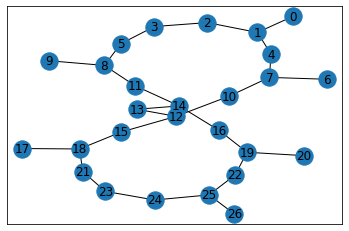

In [3]:
conf = device.configuration()
print(conf.basis_gates)
G = nx.Graph()
G.add_nodes_from(range(0,conf.n_qubits))
G.add_edges_from(conf.coupling_map)
pos = nx.kamada_kawai_layout(G)
nx.draw_networkx(G, pos, with_labels = True)

In [4]:
simBackends = provider.backends(filters=lambda x: x.configuration().n_qubits >= conf.n_qubits
                                    and x.configuration().simulator
                                    and x.status().operational==True
                                    and all(basis_gate in x.configuration().basis_gates
                                     for basis_gate in conf.basis_gates if basis_gate!="reset"))
                                     # we exclude reset because this is not physically implemented yet
simBackends

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>]

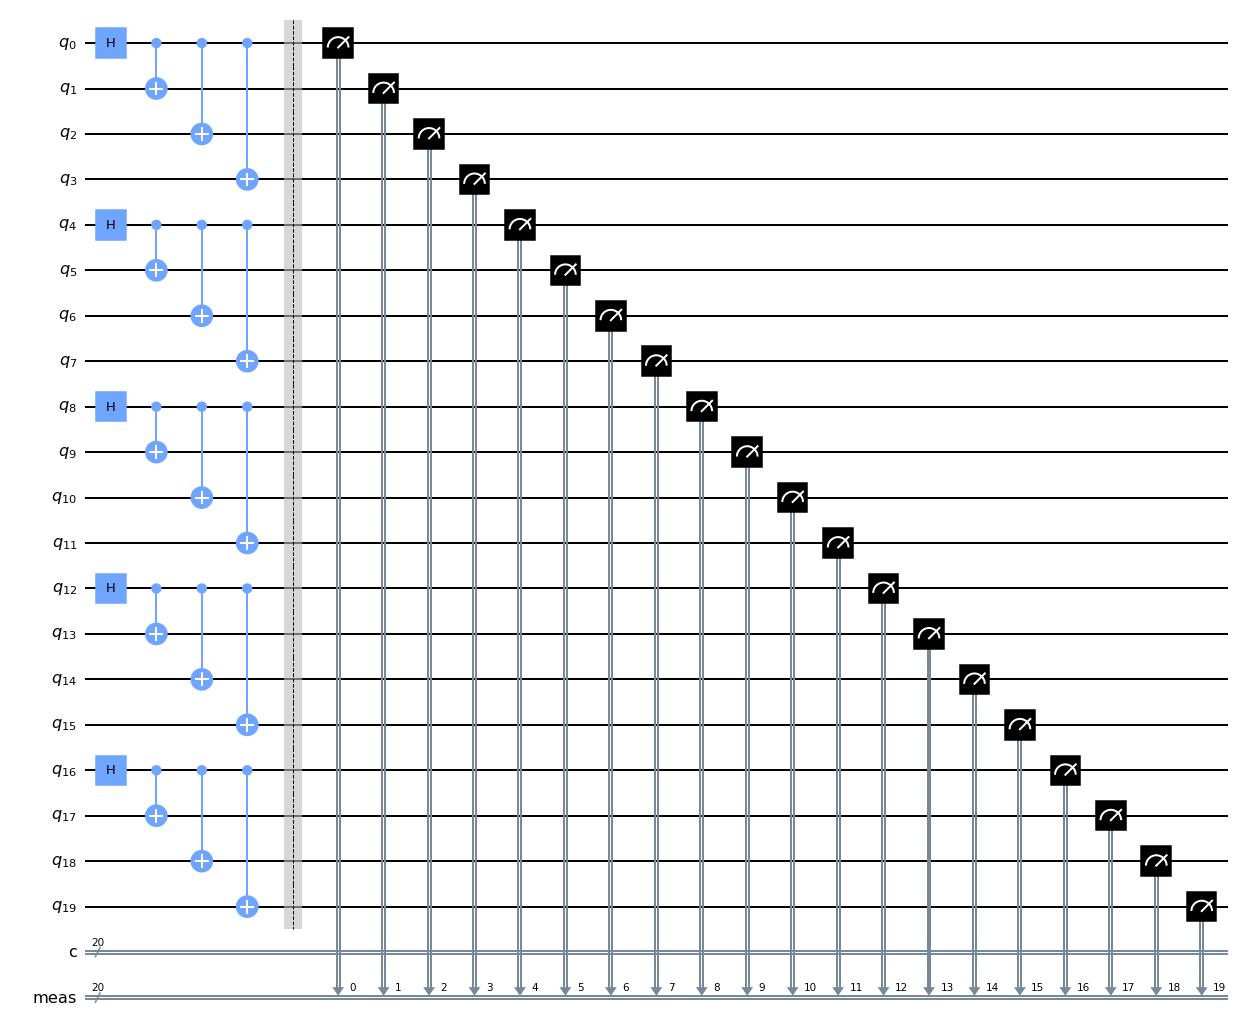

In [5]:
n_entangled = 4
n_pairs = 5
n_qubits = n_entangled * n_pairs
qc = QuantumCircuit(n_qubits, n_qubits)
qubits_in_superpos = [i for i in range(0,n_qubits, n_entangled)]
qubits_to_entangle = {i:[i + j for j in range(1, n_entangled)] for i in qubits_in_superpos}
for control in qubits_in_superpos:
    qc.h(control)
    for target in qubits_to_entangle[control]:
        qc.cx(control, target)
qc.measure_all()
qc.draw(output='mpl')

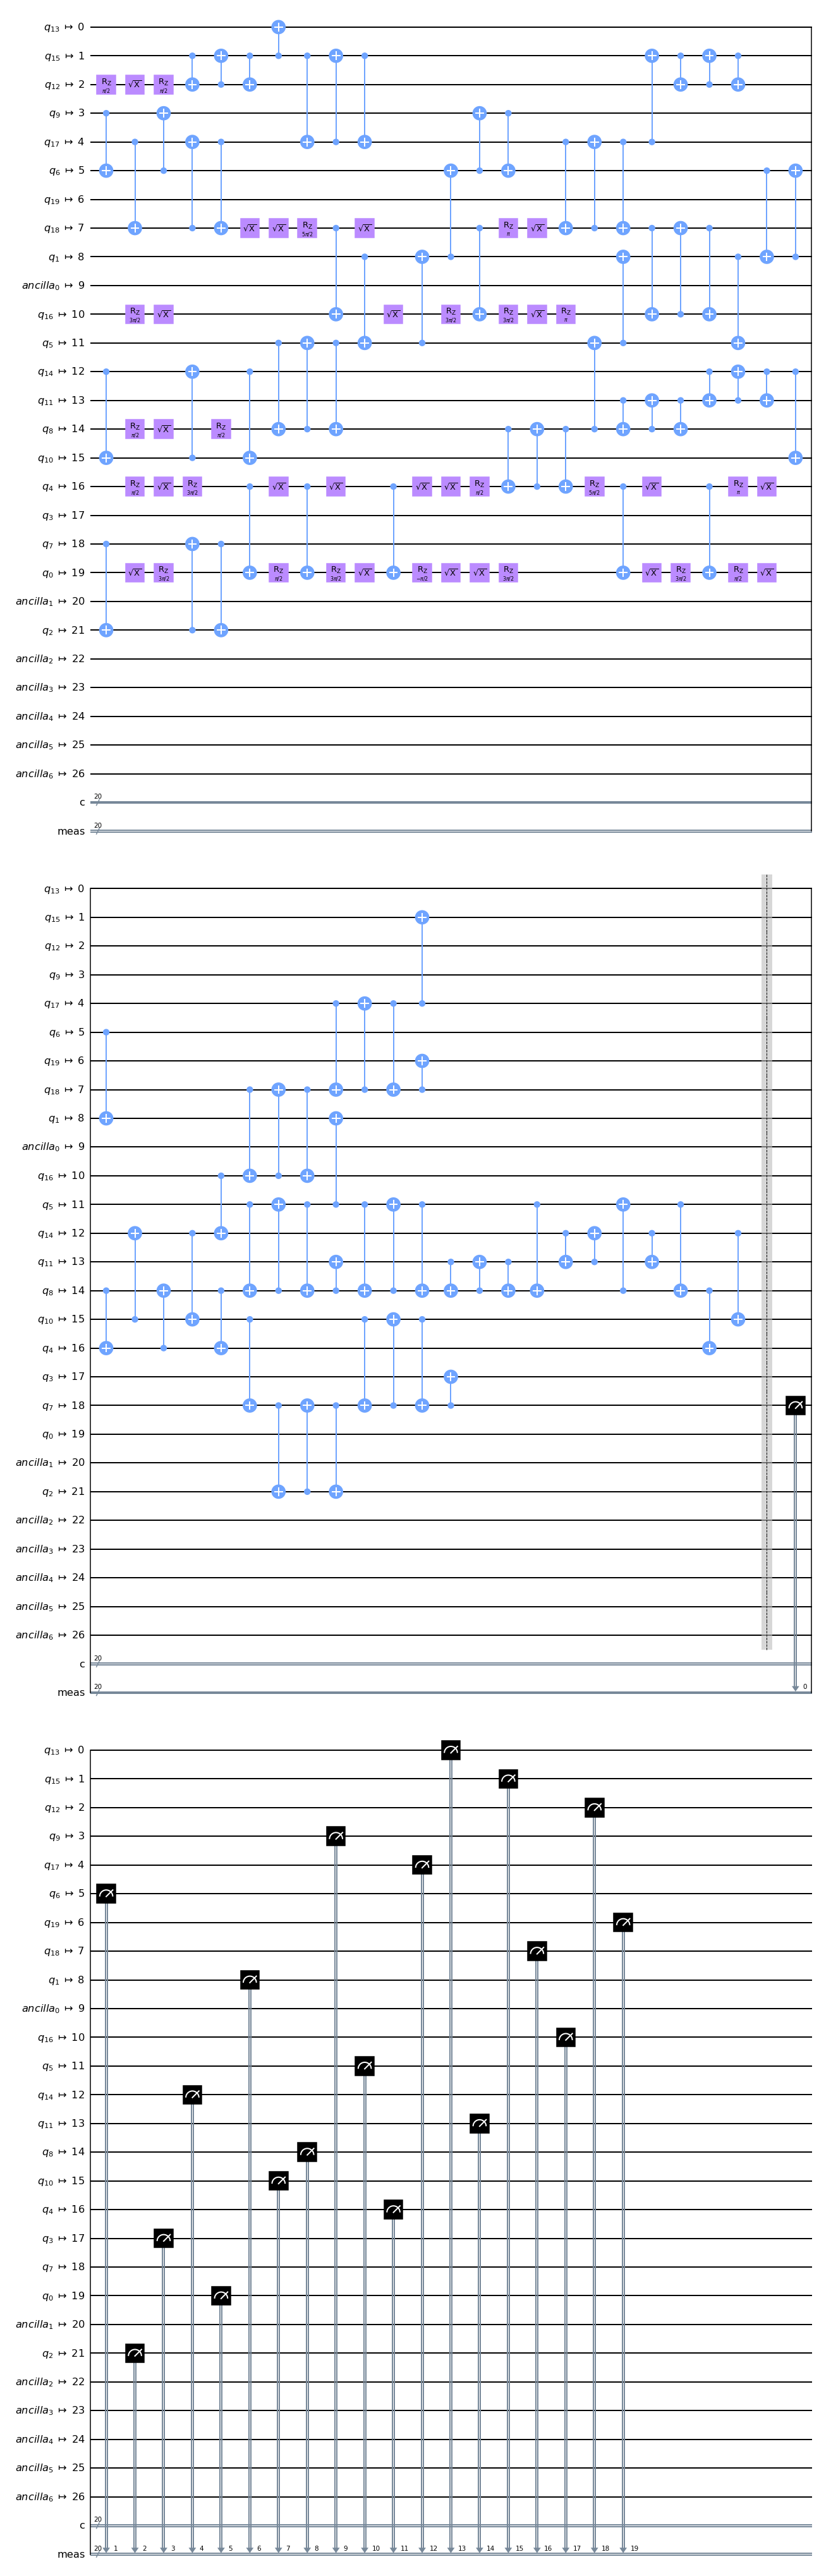

In [6]:
circuit_transpiled = transpile(qc, backend=device, optimization_level=3)
circuit_transpiled.draw(output='mpl')

In [7]:
bell_states = [x * n_entangled for x in ["0", "1"]]
possible_states = ["".join(state) for state in product(bell_states, repeat=n_pairs)]
possible_states

['00000000000000000000',
 '00000000000000001111',
 '00000000000011110000',
 '00000000000011111111',
 '00000000111100000000',
 '00000000111100001111',
 '00000000111111110000',
 '00000000111111111111',
 '00001111000000000000',
 '00001111000000001111',
 '00001111000011110000',
 '00001111000011111111',
 '00001111111100000000',
 '00001111111100001111',
 '00001111111111110000',
 '00001111111111111111',
 '11110000000000000000',
 '11110000000000001111',
 '11110000000011110000',
 '11110000000011111111',
 '11110000111100000000',
 '11110000111100001111',
 '11110000111111110000',
 '11110000111111111111',
 '11111111000000000000',
 '11111111000000001111',
 '11111111000011110000',
 '11111111000011111111',
 '11111111111100000000',
 '11111111111100001111',
 '11111111111111110000',
 '11111111111111111111']

In [8]:
backend = provider.get_backend('simulator_statevector')
shots = 4096
result = execute(qc, backend, shots=shots,
                 coupling_map=conf.coupling_map,
                 basis_gates=conf.basis_gates,
                 noise_model=noise_model).result() # took about 2 hours for problem with 26 qubits
counts = result.get_counts(0)

In [9]:
noise_ct = 0
for measurement, count in counts.items():
    measurement = measurement[:n_qubits] # drop ancillary qubits
    if measurement in possible_states:
        print(f"{measurement=} : {count=}")
    else: 
        noise_ct = noise_ct + count
print(f"{noise_ct=} valid states: {100 * (shots - noise_ct) / shots : 0.2f}%")

measurement='00000000000000000000' : count=62
measurement='00000000000000001111' : count=46
measurement='00000000000011110000' : count=39
measurement='00000000111100000000' : count=42
measurement='00001111000000000000' : count=39
measurement='11110000000000000000' : count=47
measurement='11110000000000001111' : count=37
measurement='00001111000000001111' : count=39
measurement='11110000000011110000' : count=44
measurement='11110000000011111111' : count=31
measurement='00000000111100001111' : count=47
measurement='00001111000011110000' : count=41
measurement='11110000111100000000' : count=41
measurement='11110000111100001111' : count=32
measurement='00001111000011111111' : count=31
measurement='11110000111111110000' : count=34
measurement='11110000111111111111' : count=28
measurement='00000000000011111111' : count=38
measurement='00000000111111110000' : count=31
measurement='00001111111100000000' : count=40
measurement='11111111000000000000' : count=39
measurement='11111111000000001111'